In [1]:
from ast import literal_eval

import numpy as np
import corner

import matplotlib.pyplot as plt
pltparams = {"axes.grid": False,
        "text.usetex" : True,
        "font.family" : "serif",
        "ytick.color" : "black",
        "xtick.color" : "black",
        "axes.labelcolor" : "black",
        "axes.edgecolor" : "black",
        "font.serif" : ["Computer Modern Serif"],
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "axes.labelsize": 16,
        "legend.fontsize": 16,
        "legend.title_fontsize": 16,
        "figure.titlesize": 16}

plt.rcParams.update(pltparams)

default_corner_kwargs = dict(bins=40, 
                        smooth=True, 
                        label_kwargs=dict(fontsize=16),
                        title_kwargs=dict(fontsize=16), 
                        quantiles=[],
                        levels=[0.68, 0.95],
                        plot_density=False, 
                        plot_datapoints=False, 
                        fill_contours=False,
                        max_n_ticks=4, 
                        min_n_ticks=3,
                        save=False,
                        truth_color="red")

import pandas as pd



## Systematic uncertainty 0.5 mag

Load the data

In [12]:
with open("./data/param_dict.dat", "r") as f:
    params = f.read()
params = literal_eval(params)


posterior_nmma = pd.read_csv("./nmma/injection_gaussian_posterior_samples.dat", sep=" ", header=0)
posterior_fiesta = np.load("./fiesta/results_production.npz")

Make corner plot

In [13]:
var_names = ["inclination_EM", "log10_E0", "thetaCore", "alphaWing", "log10_n0", "p", "log10_epsilon_e", "log10_epsilon_B"]
truths = [params[key] for key in var_names]

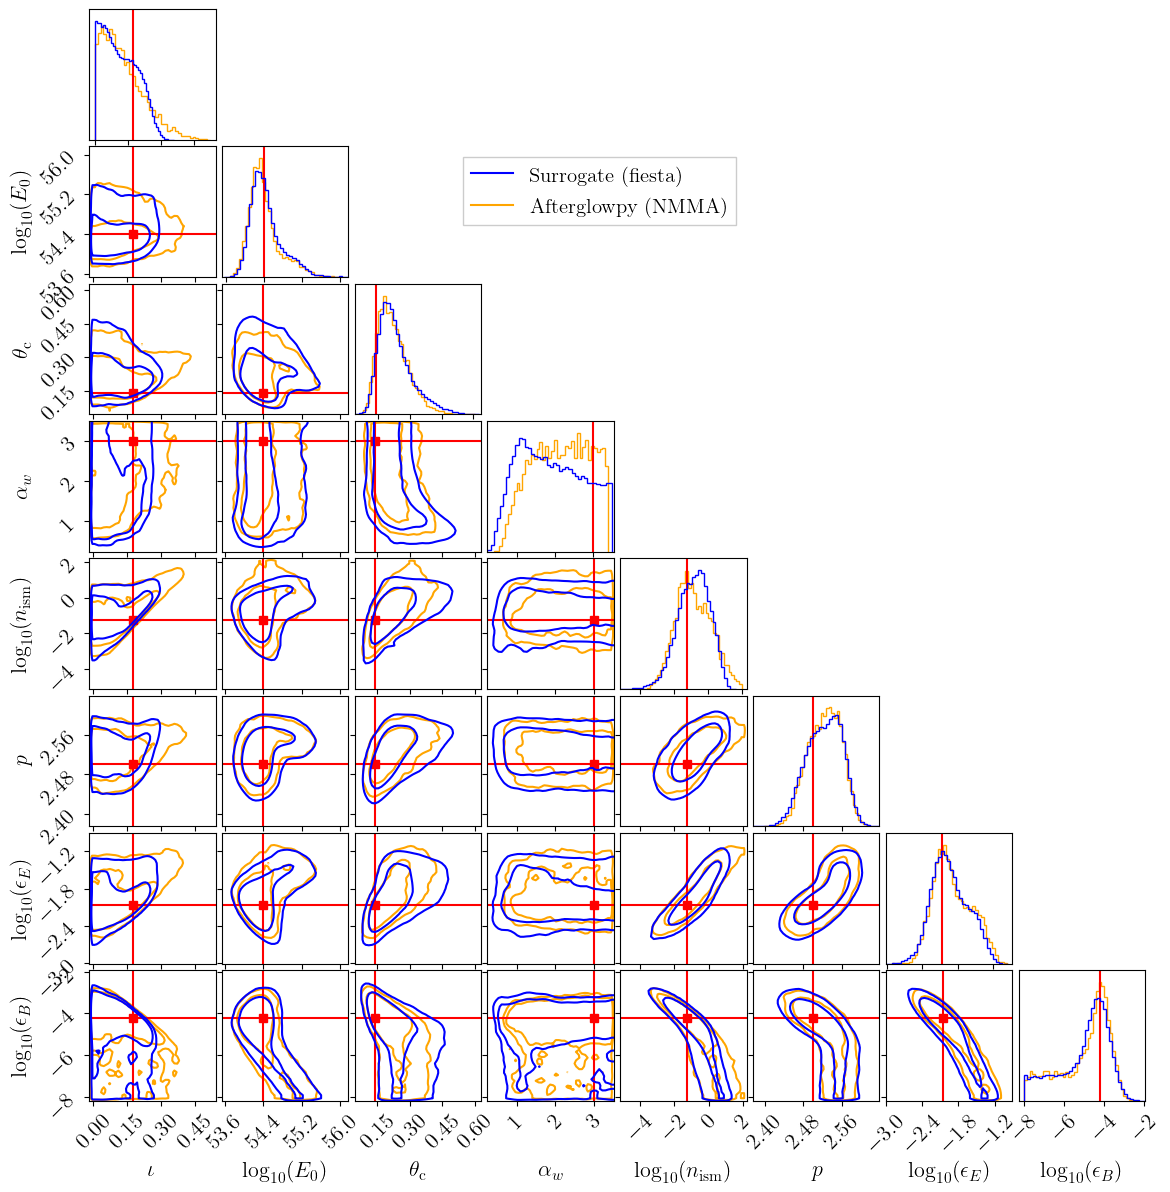

In [14]:
fig, ax = plt.subplots(8,8, figsize = (12, 12))

corner.corner(posterior_nmma[var_names], 
              truths = truths,
              fig=fig,
              color = "orange",
              labelpad = 0.15,
              labels =  ["$\\iota$", "$\log_{10}(E_0)$", "$\\theta_{\\mathrm{c}}$", "$\\alpha_w$", "$\log_{10}(n_{\mathrm{ism}})$", "$p$", "$\log_{10}(\\epsilon_E)$", "$\log_{10}(\\epsilon_B)$"],
              **default_corner_kwargs,
              hist_kwargs=dict(density=True))

corner.corner(posterior_fiesta["chains"].reshape(-1, 8),
              fig=fig,
              color="blue",
              **default_corner_kwargs,
              hist_kwargs=dict(density=True))

handles = []
for c in ["blue", "orange"]:
    handle = plt.plot([],[], color=c)[0]
    handles.append(handle)

ax[1, 4].legend(handles=handles, labels=["Surrogate (fiesta)", "Afterglowpy (NMMA)"], fontsize=15, fancybox=False, framealpha=1)
fig.subplots_adjust(left=0.08, bottom=0.08, right=0.96, top=0.99)
plt.show()

## No systematic uncertainty

Load the data

In [9]:
with open("./data/param_dict.dat", "r") as f:
    params = f.read()
params = literal_eval(params)


posterior_nmma = pd.read_csv("./nmma_no_sys_uncertainty/injection_gaussian_posterior_samples.dat", sep=" ", header=0)
posterior_fiesta = np.load("./fiesta_no_sys_uncertainty/results_production.npz")

Make corner plot

In [10]:
var_names = ["inclination_EM", "log10_E0", "thetaCore", "alphaWing", "log10_n0", "p", "log10_epsilon_e", "log10_epsilon_B"]
truths = [params[key] for key in var_names]